In [8]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

In [38]:
res = []
for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
    df = pd.read_csv(path_ds/'yaz_steak.csv')
    df.drop(columns=['DEMAND_DATE', 'STEAK'], inplace=True)
    #df_add = pd.read_csv(path_ds/'yaz_data.csv')
    #df = pd.concat([df, df_add[['WIND', 'RAINFALL', 'TEMPERATURE']]], axis=1)
    df_target = pd.read_csv(path_ds/'yaz_target.csv')
    print(df_target.columns)
    df['target'] = df_target[target]
    y_max = df.target.max()
    df.target = df.target/y_max

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    data = torch.tensor(df_scaled, dtype=torch.float32)

    N = data.shape[0]
    # make train/val/test
    #n_train = int(0.8 * N)
    n_train = 600 #
    #n_train = int(1 * N)
    train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
    test_x, test_y = data[n_train:, :-1], data[n_train:, -1]

    # make continguous
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    output_device = torch.device('cuda:0')

    train_x, train_y = train_x.to(output_device), train_y.to(output_device)
    test_x, test_y = test_x.to(output_device), test_y.to(output_device)

    n_devices = torch.cuda.device_count()
    print('Planning to run on {} GPUs.'.format(n_devices))

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = ExactGPModel(train_x, train_y, likelihood).cuda()

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    training_iter=100

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        #observed_pred_train = likelihood(model(train_x))

    ## NV

    #y_train_unscaled = scaler.inverse_transform(df[n_train:,:])[:,-1]
    y_train_unscaled = (scaler.inverse_transform(df_scaled[:n_train,:])[:,-1])*y_max
    y_test_unscaled = (scaler.inverse_transform(df_scaled[n_train:,:])[:,-1])*y_max

    n_features = df_scaled.shape[1]
    nv_means = observed_pred.mean.cpu().numpy()
    #nv_means = observed_pred_train.mean.cpu().numpy()
    nv_means_unscaled = (scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1])*y_max

    nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
    #nv_sigma = np.sqrt(torch.diag(observed_pred_train.covariance_matrix).cpu().detach().numpy())
    nv_sigma_unscaled = (scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1])*y_max

    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
        nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
        cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp", "target": target})
        res.append(ser_tmp)
df_res = pd.DataFrame(res)
#df_res.to_csv(path/'res_data'/'gp_all.csv', index=False)

Index(['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK'], dtype='object')
Planning to run on 1 GPUs.
Iter 1/100 - Loss: 0.939   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.898   lengthscale: 0.744   noise: 0.644
Iter 3/100 - Loss: 0.856   lengthscale: 0.798   noise: 0.598
Iter 4/100 - Loss: 0.813   lengthscale: 0.854   noise: 0.554
Iter 5/100 - Loss: 0.768   lengthscale: 0.913   noise: 0.513
Iter 6/100 - Loss: 0.722   lengthscale: 0.975   noise: 0.474
Iter 7/100 - Loss: 0.674   lengthscale: 1.039   noise: 0.437
Iter 8/100 - Loss: 0.626   lengthscale: 1.106   noise: 0.402
Iter 9/100 - Loss: 0.576   lengthscale: 1.176   noise: 0.370
Iter 10/100 - Loss: 0.527   lengthscale: 1.248   noise: 0.340
Iter 11/100 - Loss: 0.476   lengthscale: 1.322   noise: 0.312
Iter 12/100 - Loss: 0.426   lengthscale: 1.399   noise: 0.285
Iter 13/100 - Loss: 0.376   lengthscale: 1.478   noise: 0.261
Iter 14/100 - Loss: 0.326   lengthscale: 1.558   noise: 0.238
Iter 15/100 - Loss: 0.

nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

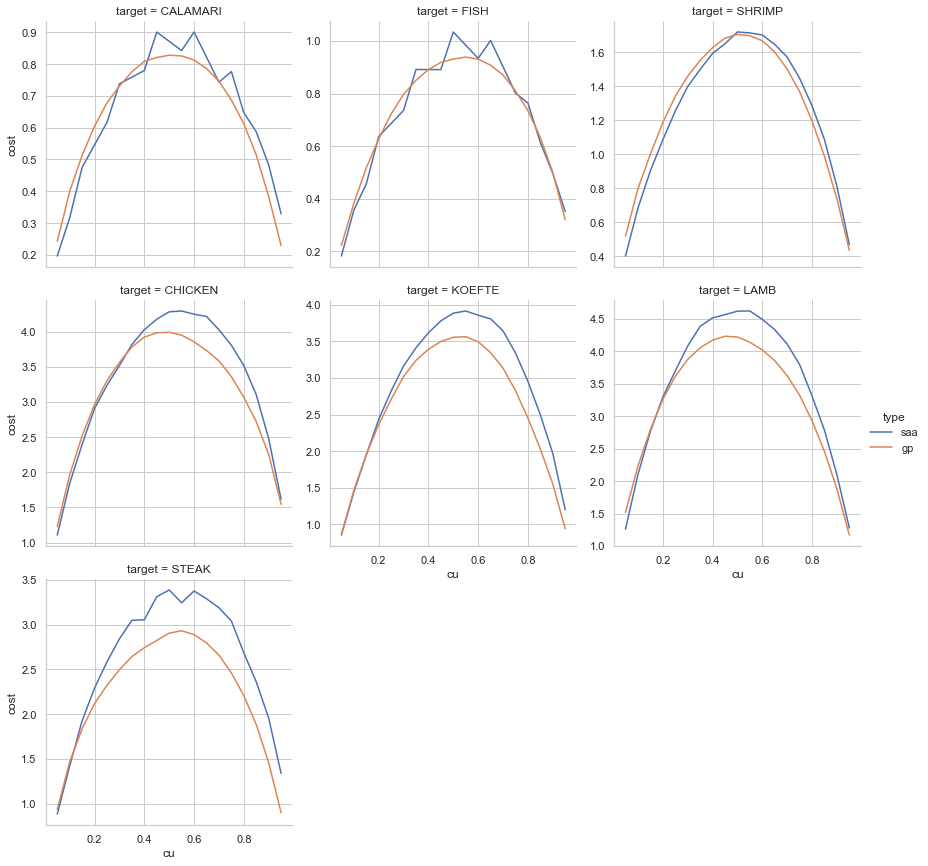

In [39]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
df_plot = df_plot[~(df_plot.type.isin(["rf_rf", "rf_grf", "rf_oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},
    col="target", hue="type",kind="line", aspect=1, height=4); 


## Plot Space

f0 = [torch.linspace(0.5, 0.5, 200) for i in range(26)]
fx = torch.linspace(0,1, 200) #temp
fn = []#[torch.linspace(0.5, 0.5, 200) for i in range(2)]


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    sample_x = torch.stack([*f0,fx,*fn] , axis=-1).cuda()
    observed_pred = likelihood(model(sample_x))

feature_idx=26
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    # Plot predictive means as blue line
    ax.plot(fx.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])